In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('data/data.csv')
df.head()

,fin_type,admission_date,height,weight,age,gender,hosp_3,hosp_procedure,hosp_method,purpose,channel,diagnosis_main,diagnosis_concom,hosp_days
0,45,20201203,170.0,70.0,85,1,2,2,2,4,5,975,2010,4
1,45,20170108,154.0,63.0,79,2,3,3,3,0,6,2700,2010,12
2,45,20170804,154.0,63.0,79,2,2,2,2,4,5,1621,812,9
3,45,20170906,154.0,63.0,79,2,3,2,2,2,5,2851,830,14
4,38,20180525,154.0,63.0,79,2,2,2,2,2,5,1177,2010,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fin_type          100000 non-null  int64  
 1   admission_date    100000 non-null  int64  
 2   height            100000 non-null  float64
 3   weight            100000 non-null  float64
 4   age               100000 non-null  int64  
 5   gender            100000 non-null  int64  
 6   hosp_3            100000 non-null  int64  
 7   hosp_procedure    100000 non-null  int64  
 8   hosp_method       100000 non-null  int64  
 9   purpose           100000 non-null  int64  
 10  channel           100000 non-null  int64  
 11  diagnosis_main    100000 non-null  int64  
 12  diagnosis_concom  100000 non-null  int64  
 13  hosp_days         100000 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 10.7 MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fin_type,100000.0,4.057674e+01,13.527293,0.0,45.0,45.0,45.0,64.0
admission_date,100000.0,2.018140e+07,9613.705879,20170101.0,20170928.0,20180605.0,20190317.0,20201222.0
height,100000.0,1.475635e+02,55.052709,0.0,158.0,165.0,174.0,903.0
weight,100000.0,7.223580e+01,124.165641,0.0,59.0,72.0,86.0,12600.0
age,100000.0,5.618989e+01,17.925656,0.0,43.0,59.0,70.0,106.0
gender,100000.0,1.574740e+00,0.494385,1.0,1.0,2.0,2.0,2.0
hosp_3,100000.0,2.173570e+00,0.381503,0.0,2.0,2.0,2.0,3.0
hosp_procedure,100000.0,2.177650e+00,0.383004,0.0,2.0,2.0,2.0,4.0
hosp_method,100000.0,2.132510e+00,0.603121,0.0,2.0,2.0,2.0,5.0
purpose,100000.0,1.521420e+00,1.608231,0.0,0.0,2.0,2.0,8.0


In [5]:
df_train, df_test = train_test_split(
    df,
    test_size=0.1,
    random_state=100,
    shuffle=True,
)

print(f'Shape of train dataframe: {df_train.shape}')
print(f'Shape of test dataframe: {df_test.shape}')

Shape of train dataframe: (90000, 14)
Shape of test dataframe: (10000, 14)


### Let's make some new features
#### Feature: hosp_days_mean

In [6]:
class Hosp_days():
    def __init__(self):
        self.hosp_days_mean = None
        self.hosp_days_max = 21

    def fit(self, df):
        # mean value of hospitalization days for each unique diagnosis
        self.hosp_days_mean = df.groupby('diagnosis_main', as_index=False)\
            .agg({'hosp_days': 'mean'})\
            .rename(columns={'hosp_days': 'hosp_days_mean'})

    def transform(self, df):
        df = df.merge(self.hosp_days_mean, on=['diagnosis_main'], how='left')
        df['hosp_days_mean'].fillna(0, inplace=True)
        df.loc[df['hosp_days_mean'] > self.hosp_days_max ,'hosp_days_mean'] = self.hosp_days_max
        return df

hosp_days = Hosp_days()
hosp_days.fit(df_train)
df_train = hosp_days.transform(df_train)
df_test = hosp_days.transform(df_test)

#### Date features

In [7]:
def proc_admission_date(df):
    df['date'] = pd.to_datetime(df['admission_date'], format='%Y%m%d')
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['day'] = pd.DatetimeIndex(df['date']).day
    df['dayofyear'] = pd.DatetimeIndex(df['date']).dayofyear
    df['weekofyear'] = pd.DatetimeIndex(df['date']).weekofyear
    df['weekday'] = pd.DatetimeIndex(df['date']).weekday
    df['quarter'] = pd.DatetimeIndex(df['date']).quarter

    df = df.drop(['date', 'admission_date'], axis=1)
    return df

df_train = proc_admission_date(df_train)
df_test = proc_admission_date(df_test)

#### Drop height and weight

In [8]:
df_train = df_train.drop(['height', 'weight'], axis=1)
df_test = df_test.drop(['height', 'weight'], axis=1)

### Let's look at the correlation matrix

Text(0.5, 1.0, 'Correlation matrix')

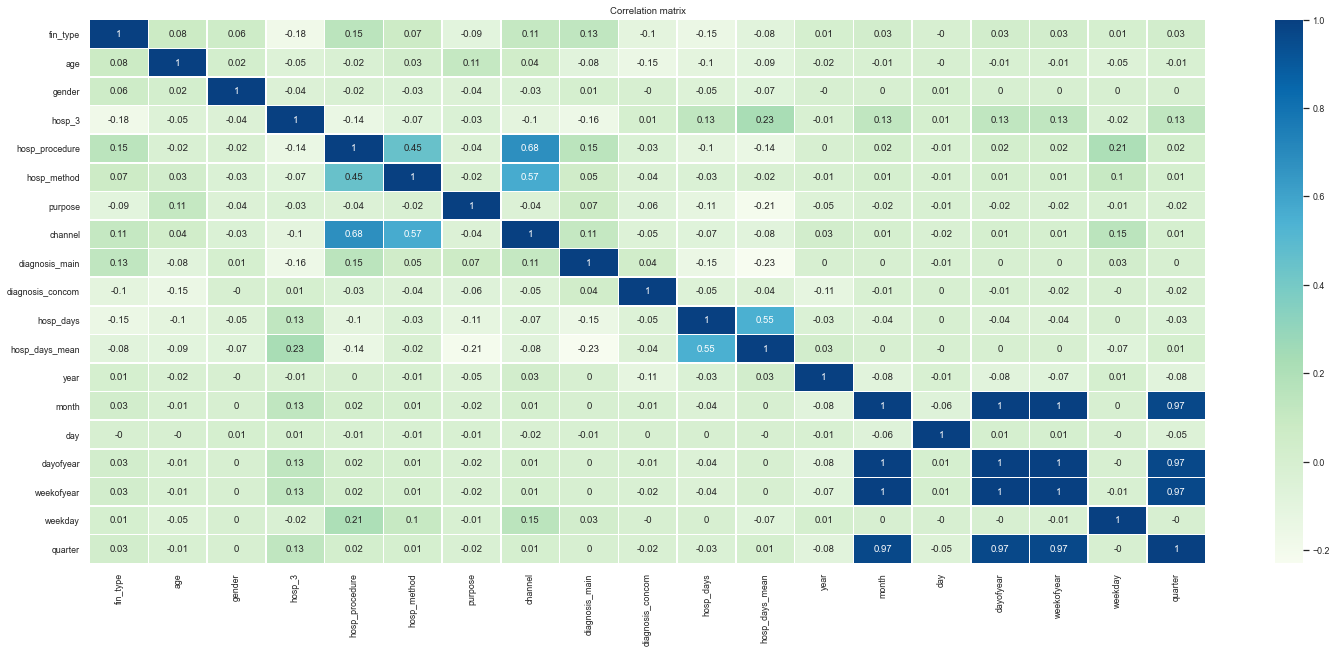

In [9]:
plt.figure(figsize = (25,10))
sns.set(font_scale=0.8)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')

In [10]:
target_feature = 'hosp_days'
all_features = df_train.drop(target_feature, axis=1).columns.to_list()

Text(0.5, 1.0, 'Correlation with target variable')

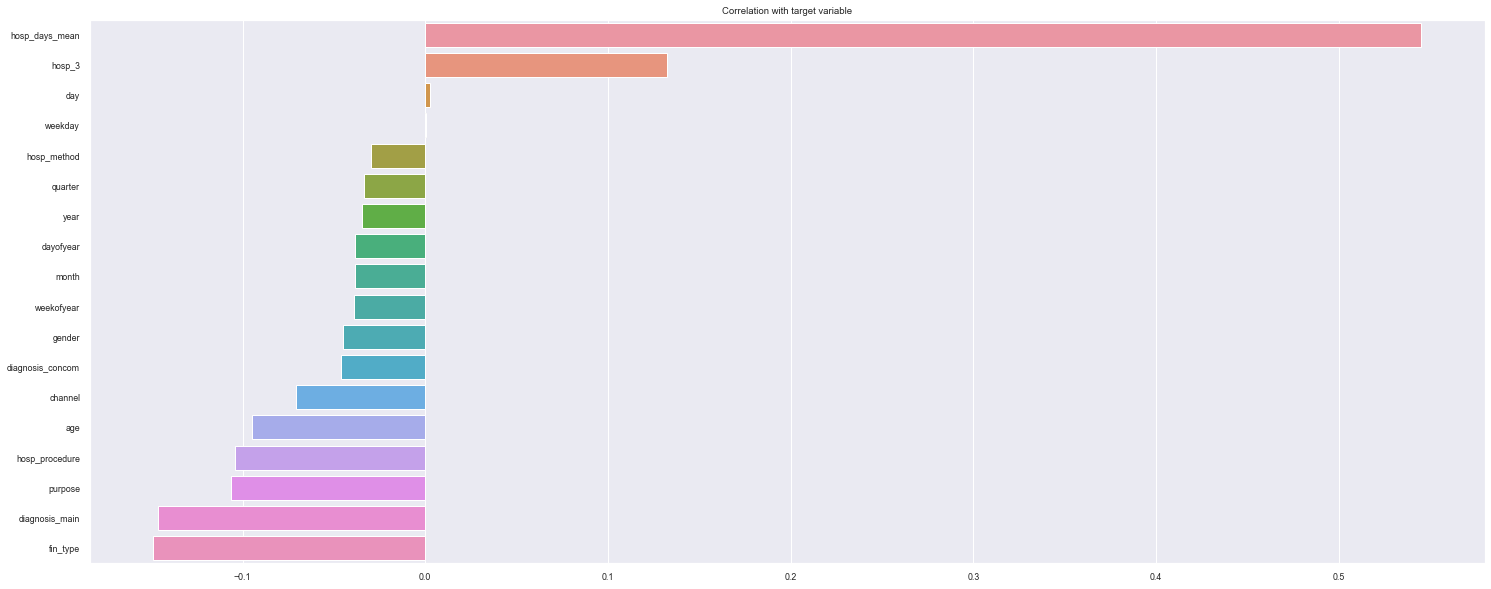

In [11]:
corr_with_target = df_train[all_features + [target_feature]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(25, 10))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')

### Let's look at all numeric features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D549C3E588>,
      dtype=object)

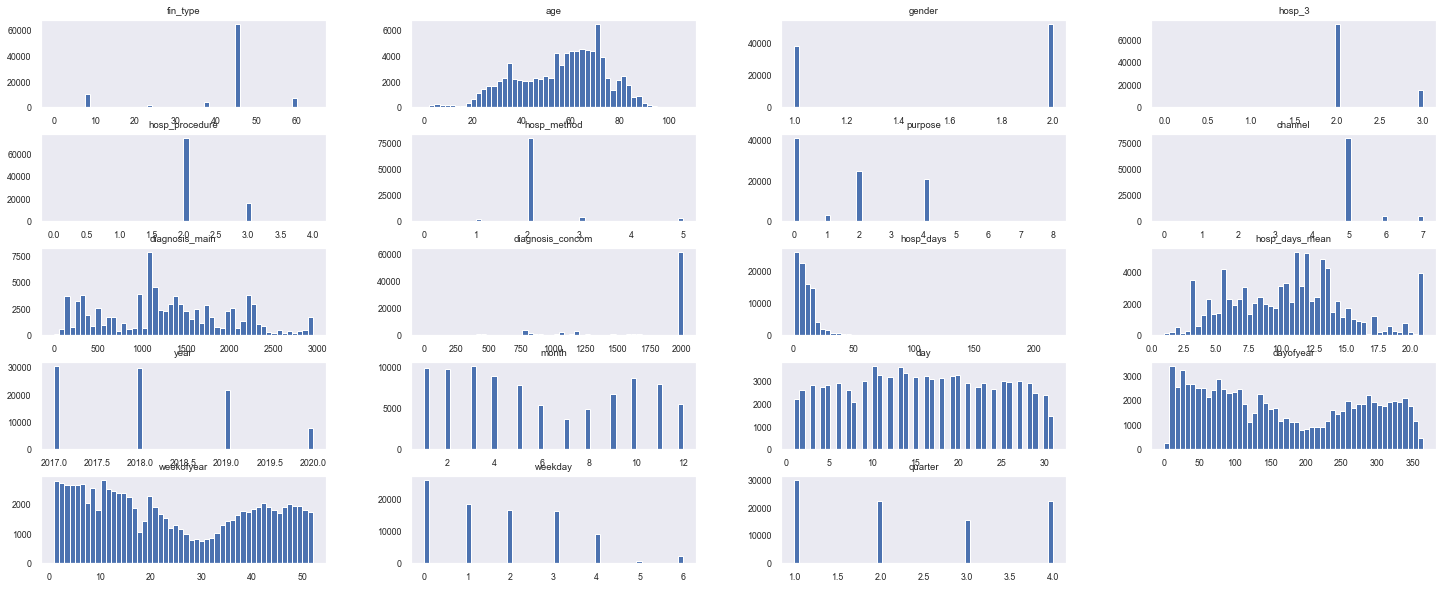

In [12]:
df_train.hist(figsize=(25,10), bins=50, grid=False)

In [13]:
X_train = df_train[all_features]
y_train = df_train[target_feature]

model = CatBoostRegressor(
    eval_metric='R2',
    early_stopping_rounds=20,
    boosting_type='Ordered',
)

rs = model.randomized_search(
    {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.03, 0.1, 0.3, 0.5],
        'iterations': [100, 200, 400, 800, 1000],
        'l2_leaf_reg': [2, 2.5, 3, 3.5, 4, 4.5],
        'bagging_temperature': [1.5, 2, 2.5, 3, 3.5],
    },
    X_train,
    y_train,
    cv=10,
    n_iter=10,
    shuffle=True,
    partition_random_seed=100,
    calc_cv_statistics=True,
)


bestTest = 0.4271113363
bestIteration = 799

0:	loss: 0.4271113	best: 0.4271113 (0)	total: 15.1s	remaining: 2m 15s

bestTest = 0.4377193533
bestIteration = 91

1:	loss: 0.4377194	best: 0.4377194 (1)	total: 19.6s	remaining: 1m 18s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4399053596
bestIteration = 302

2:	loss: 0.4399054	best: 0.4399054 (2)	total: 33.5s	remaining: 1m 18s

bestTest = 0.4421821638
bestIteration = 399

3:	loss: 0.4421822	best: 0.4421822 (3)	total: 50.6s	remaining: 1m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4396103889
bestIteration = 107

4:	loss: 0.4396104	best: 0.4421822 (3)	total: 1m 26s	remaining: 1m 26s

bestTest = 0.4364688571
bestIteration = 99

5:	loss: 0.4364689	best: 0.4421822 (3)	total: 1m 30s	remaining: 1m

bestTest = 0.3995181479
bestIteration = 99

6:	loss: 0.3995181	best: 0.4421822 (3)	total: 1m 57s	remaining: 50.5s

bestTest = 0.4361178848
bestIteration = 196

7:	loss: 0.4361179	best: 0.4421822 (3)	

In [14]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, model.get_feature_importance()),
    columns=['feature_name', 'importance'],
)
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
10,hosp_days_mean,29.321027
1,age,14.068657
0,fin_type,13.829251
8,diagnosis_main,11.839230
14,dayofyear,7.280226
11,year,5.716408
9,diagnosis_concom,3.955965
6,purpose,3.801065
16,weekday,2.329916
13,day,2.260630


In [15]:
print(f'R2 train: {model.score(X_train, y_train)}')
print(f'R2 test: {model.score(df_test[all_features], df_test[target_feature])}')

R2 train: 0.5620488574131837
R2 test: 0.3767447931794189
